# Hands-on
## Clustering, spatial clustering, and geodemographics

This session covers statistical clustering of spatial observations. Many questions and topics are complex phenomena that involve several dimensions and are hard to summarize into a single variable. In statistical terms, we call this family of problems *multivariate*, as oposed to *univariate* cases where only a single variable is considered in the analysis. Clustering tackles this kind of questions by reducing their dimensionality -the number of relevant variables the analyst needs to look at- and converting it into a more intuitive set of classes that even non-technical audiences can look at and make sense of. For this reason, it is widely use in applied contexts such as policymaking or marketting. In addition, since these methods do not require many preliminar assumptions about the structure of the data, it is a commonly used exploratory tool, as it can quickly give clues about the shape, form and content of a dataset.

The basic idea of statistical clustering is to summarize the information contained in several variables by creating a relatively small number of categories. Each observation in the dataset is then assigned to one, and only one, category depending on its values for the variables originally considered in the classification. If done correctly, the exercise reduces the complexity of a multi-dimensional problem while retaining all the meaningful information contained in the original dataset. This is because, once classified, the analyst only needs to look at in which category every observation falls into, instead of considering the multiple values associated with each of the variables and trying to figure out how to put them together in a coherent sense. When the clustering is performed on observations that represent areas, the technique is often called geodemographic analysis.

Although there exist many techniques to statistically group observations in a dataset, all of them are based on the premise of using a set of attributes to define classes or categories of observations that are similar *within* each of them, but differ *between* groups. How similarity within groups and dissimilarity between them is defined and how the classification algorithm is operationalized is what makes techniques differ and also what makes each of them particularly well suited for specific problems or types of data. As an illustration, we will only dip our toes into one of these methods, K-means, which is probably the most commonly used technique for statistical clustering.

In the case of analysing spatial data, there is a subset of methods that are of particular interest for many common cases in Geographic Data Science. These are the so-called *regionalization* techniques. Regionalization methods can take also many forms and faces but, at their core, they all involve statistical clustering of observations with the additional constraint that observations need to be geographical neighbors to be in the same category. Because of this, rather than category, we will use the term *area* for each observation and *region* for each category, hence regionalization, the construction of regions from smaller areas.

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

## Data

The dataset we will use in this occasion is an extract from the online website [AirBnb](http://www.airbnb.com). AirBnb is a company that provides a meeting point for people looking for an alternative to a hotel when they visit a city, and locals who want to rent (part of) their house to make some extra money. The website has a continuously updated listing of all the available properties in a given city that customers can check and book through. In addition, the website also provides a feedback mechanism by which both ends, hosts and guests, can rate their experience. Aggregating ratings from guests about the properties where they have stayed, AirBnb provides additional information for every property, such as an overall cleanliness score or an index of how good the host is at communicating with the guests.

The original data are provided at the property level and for the entire London. However, since the total number of properties is very large for the purposes of this notebook, they have been aggregated at the Middle Super Output Area (MSOA), a geographical unit created by the Office of National Statistics. Although the original source contains information for the Greater London, the vast majority of properties are located in Inner London, so the data we will use is restricted to that extent. Even in this case, not every polygon has at least one property. To avoid cases of missing values, the final dataset only contains those MSOAs with at least one property, so there can be average ratings associated with them.

Our goal in this notebook is to create a classification of areas (MSOAs) in Inner London based on the ratings of the AirBnb locations. This will allow us to create a typology for the geography of AirBnb in London and, to the extent the AirBnb locations can say something about the areas where they are located, the classification will help us understand the geography of residential London a bit better. One general caveat about the conclusions we can draw from an analysis like this one that derives from the nature of AirBnb data. On the one hand, this dataset is a good example of the kind of analyses that the data revolution is making possible as, only a few years ago, it would have been very hard to obtain a similarly large survey of properties with ratings like this one. On the other hand, it is important to keep in mind the kinds of biases that these data are subject to and thus the limitations in terms of generalizing findings to the general population. At any rate, this dataset is a great example to learn about statistical clustering of spatial observations, both in a geodemographic as well as in a regionalization.

Let's start by reading the main table of MSOAs in:

````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [2]:
# Read the file in
abb = gpd.read_file("https://darribas.org/gds_course/content/data/london_abb.gpkg")

````{admonition} Alternative
Instead of reading the file directly off the web, it is possible to download it manually, store it on your computer, and read it locally. To do that, you can follow these steps:
1. Download the file by right-clicking on <a href="../data/london_abb.gpkg"> this link </a> and saving the file
1. Place the file on the _same folder as the notebook_ where you intend to read it
1. Replace the code in the cell above by:
```python
abb = gpd.read_file("london_abb.gpkg")
```
````

In [3]:
# Inspect the structure of the table
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   MSOA_CODE                    353 non-null    object  
 1   accommodates                 353 non-null    float64 
 2   bathrooms                    353 non-null    float64 
 3   bedrooms                     353 non-null    float64 
 4   beds                         353 non-null    float64 
 5   number_of_reviews            353 non-null    float64 
 6   reviews_per_month            353 non-null    float64 
 7   review_scores_rating         353 non-null    float64 
 8   review_scores_accuracy       353 non-null    float64 
 9   review_scores_cleanliness    353 non-null    float64 
 10  review_scores_checkin        353 non-null    float64 
 11  review_scores_communication  353 non-null    float64 
 12  review_scores_location       353 non-null    float64 
 1

Before we jump into exploring the data, one additional step that will come in handy down the line. Not every variable in the table is an attribute that we will want for the clustering. In particular, we are interested in review ratings, so we will only consider those. Hence, let us first manually write them so they are easier to subset:

In [4]:
ratings = ['review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 
           'review_scores_communication', 'review_scores_location',
           'review_scores_value']

Later in the section, we will also use what AirBnb calls neighborhoods. Let's load them in so they are ready when we need them.


````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [5]:
boroughs = gpd.read_file("https://darribas.org/gds_course/content/data/london_inner_boroughs.geojson")

Note that, in comparison to previous datasets, this one is provided in a new format, `.geojson`. GeoJSON files are a plain text file (you can open it on any text editor and see its contents) that follows the structure of the JSON format, widely used to exchange information over the web, adapted for geographic data, hence the `geo` at the front. GeoJSON files have gained much popularity with the rise of web mapping and are quickly becoming a de-facto standard for small datasets because they are readable by humans and by many different platforms. As you can see above, reading them in Python is exactly the same as reading a shapefile, for example.

## Getting to know the data

The best way to start exploring the geography of AirBnb ratings is by plotting each of them into a different map. This will give us a univariate perspective on each of the variables we are interested in.

Since we have many columns to plot, we will create a loop that generates each map for us and places it on a "subplot" of the main figure:

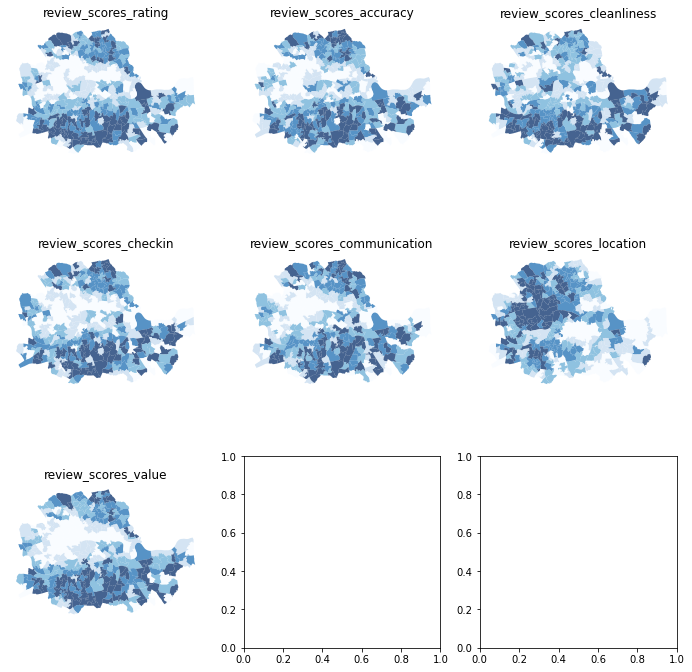

In [6]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(column=col, ax=ax, scheme='Quantiles', \
             linewidth=0, cmap='Blues', alpha=0.75)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Before we delve into the substantive interpretation of the map, let us walk through the process of creating the figure above, which involves several subplots inside the same figure:

* First (L. 2) we set the number of rows and columns we want for the grid of subplots.
* The resulting object, `axs`, is not a single one but a grid (or array) of axis. Because of this, we can't plot directly on `axs`, but instead we need access each individual axis.
* To make that step easier, we *unpack* the grid into a flat list (array) for the axes of each subplot with `flatten` (L. 4).
* At this point, we set up a `for` loop (L. 6) to plot a map in each of the subplots.
* Within the loop (L. 6-14), we extract the axis (L. 8), plot the choropleth on it (L. 10) and style the map (L. 11-14).
* Display the figure (L. 16).

As we can see, there is substantial variation in how the ratings for different aspects are distributed over space. While variables like the overall value (`review_scores_value`) or the communication (`review_scores_communication`) tend to higher in peripheral areas, others like the location score (`review_scores_location`) are heavily concentrated in the city centre.

Even though we only have seven variables, it is very hard to "mentally overlay" all of them to come up with an overall assessment of the nature of each part of London. For bivariate correlations, a useful tool is the correlation matrix plot, available in `seaborn`:

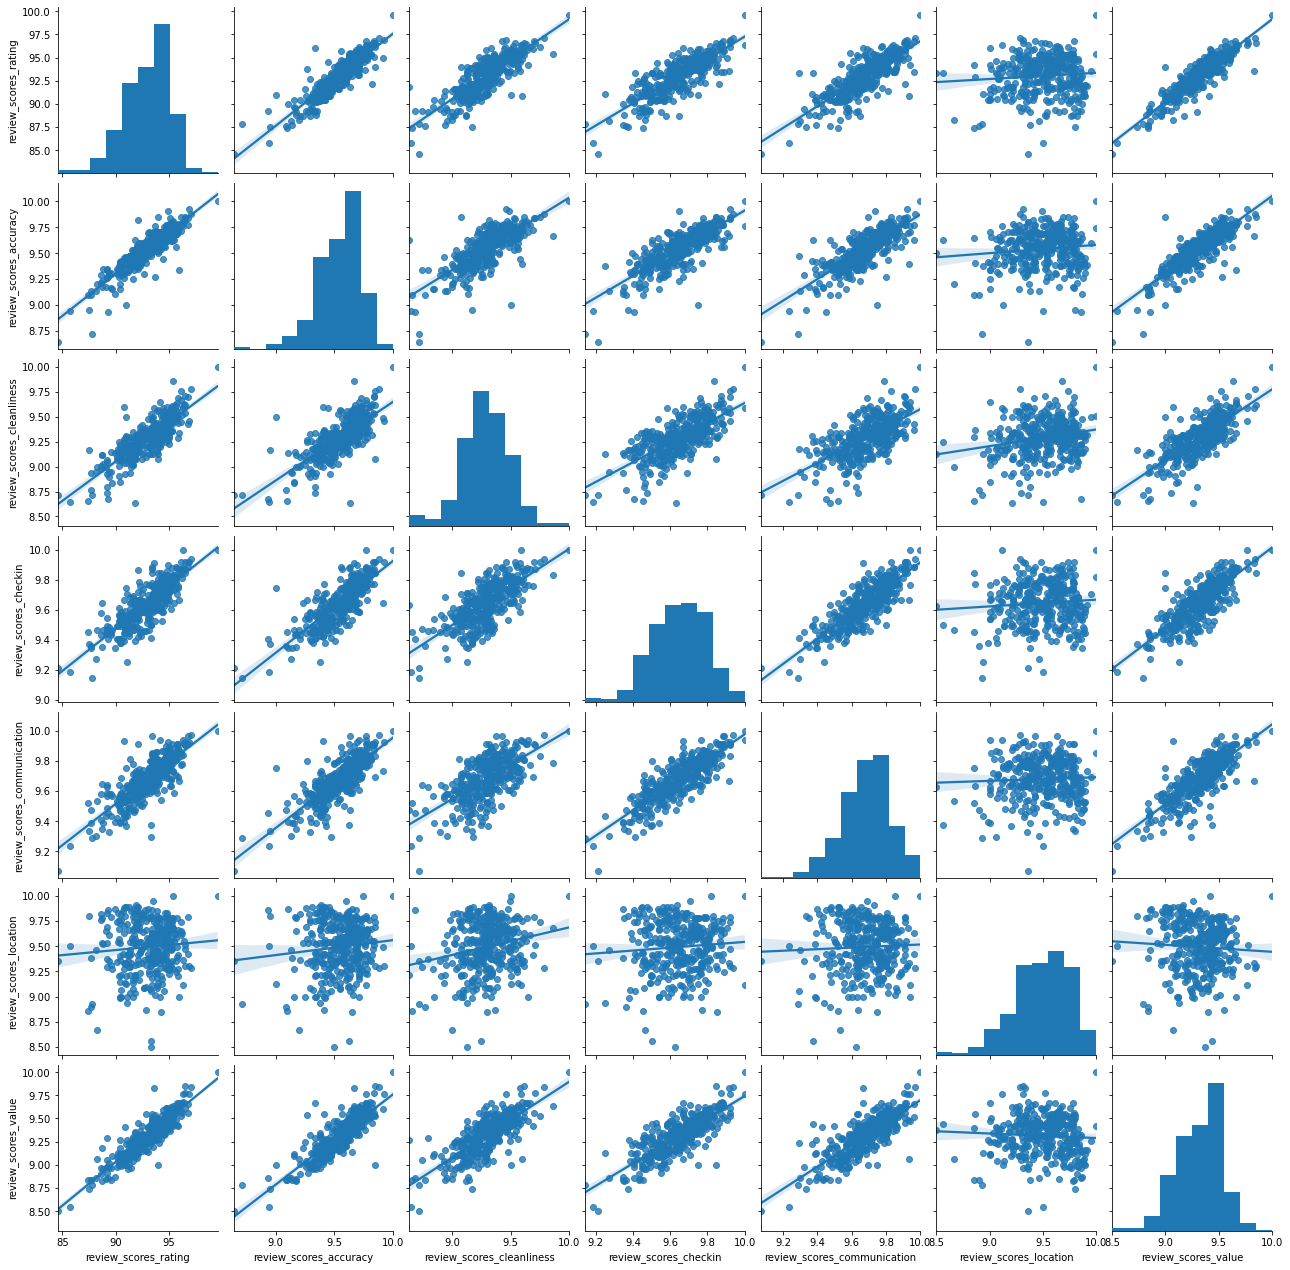

In [7]:
_ = sns.pairplot(abb[ratings], kind='reg', diag_kind='hist')

This is helpful to consider uni and bivariate questions such as: *what is the relationship between the overall (`rating`) and location scores?* (Positive) *Are the overall ratings more correlated with location or with cleanliness?* (Cleanliness) However, sometimes, this is not enough and we are interested in more sophisticated questions that are truly multivariate and, in these cases, the figure above cannot help us. For example, it is not straightforward to answer questions like: *what are the main characteristics of the South of London?* *What areas are similar to the core of the city?* *Are the East and West of London similar in terms of the kind of AirBnb properties you can find in them?* For these kinds of multi-dimensional questions -involving multiple variables at the same time- we require a truly multidimensional method like statistical clustering.

## An AirBnb geodemographic classification of Inner London using K-means

A geodemographic analysis involves the classification of the areas that make up a greographical map into groups or categories of observations that are similar within each other but different between them. The classification is carried out using a statistical clustering algorithm that takes as input a set of attributes and returns the group ("labels" in the terminology) each observation belongs to. Depending on the particular algorithm employed, additional parameters, such as the desired number of clusters employed or more advanced tuning parameters (e.g. bandwith, radius, etc.), also need to be entered as inputs. For our geodemographic classification of AirBnb ratings in Inner London, we will use one of the most popular clustering algorithms: K-means. This technique only requires as input the observation attributes and the final number of groups that we want it to cluster the observations into. In our case, we will use five to begin with as this will allow us to have a closer look into each of them.

Although the underlying algorithm is not trivial, running K-means in Python is streamlined thanks to `scikit-learn`. Similar to the extensive set of available algorithms in the library, its computation is a matter of two lines of code. First, we need to specify the parameters in the `KMeans` method (which is part of `scikit-learn`'s `cluster` submodule). Note that, at this point, we do not even need to pass the data:

In [8]:
kmeans5 = cluster.KMeans(n_clusters=5, random_state=12345)

This sets up an object that holds all the parameters required to run the algorithm. In our case, we only passed the number of clusters(`n_clusters`) and the random state, a number that ensures every run of K-Means, which remember relies on random initialisations, is the same and thus reproducible.

To actually run the algorithm on the attributes, we need to call the `fit` method in `kmeans5`:

In [9]:
# Run the clustering algorithm
k5cls = kmeans5.fit(abb[ratings])

The `k5cls` object we have just created contains several components that can be useful for an analysis. For now, we will use the labels, which represent the different categories in which we have grouped the data. Remember, in Python, life starts at zero, so the group labels go from zero to four. Labels can be  extracted as follows:

In [10]:
k5cls.labels_

array([4, 1, 1, 1, 3, 3, 1, 0, 4, 0, 3, 0, 4, 0, 0, 0, 1, 3, 3, 4, 4, 4,
       2, 2, 2, 2, 2, 4, 4, 2, 4, 4, 0, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3,
       1, 3, 3, 3, 1, 1, 0, 2, 4, 3, 3, 3, 3, 1, 1, 1, 4, 1, 1, 3, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 0, 0,
       0, 3, 3, 0, 3, 3, 0, 3, 3, 4, 3, 4, 0, 2, 4, 4, 0, 3, 3, 0, 4, 1,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 4,
       0, 4, 0, 0, 4, 3, 3, 0, 3, 0, 1, 3, 2, 0, 0, 4, 4, 2, 4, 4, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 1, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1,
       1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 0, 3, 0, 3, 1, 3,
       1, 3, 3, 3, 1, 3, 3, 1, 1, 0, 1, 4, 1, 1, 1, 1, 2, 3, 0, 1, 3, 1,
       1, 3, 2, 1, 1, 0, 3, 4, 3, 0, 3, 3, 0, 4, 0, 1, 4, 4, 0, 4, 4, 3,
       4, 0, 0, 3, 3, 3, 0, 3, 3, 0, 1, 3, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3,
       3, 0, 0, 4, 3, 0, 4, 2, 1, 4, 0, 2, 4, 2, 1, 4, 0, 4, 2, 4, 0, 4,
       4, 3, 0, 4, 2, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1,

Each number represents a different category, so two observations with the same number belong to same group. The labels are returned in the same order as the input attributes were passed in, which means we can append them to the original table of data as an additional column:

In [11]:
abb['k5cls'] = k5cls.labels_

### Mapping the categories

To get a better understanding of the classification we have just performed, it is useful to display the categories created on a map. For this, we will use a unique values choropleth, which will automatically assign a different color to each category:

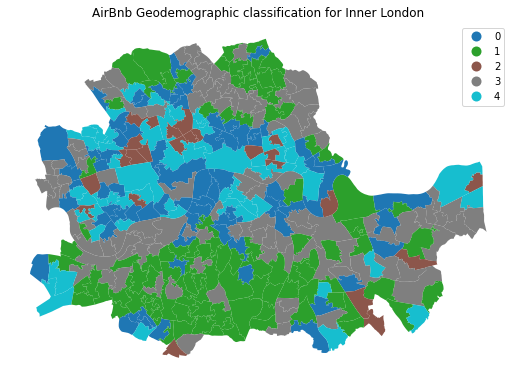

In [12]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb Geodemographic classification for Inner London')
# Display the map
plt.show()

The map above represents the geographical distribution of the five categories created by the K-means algorithm. A quick glance shows a strong spatial structure in the distribution of the colors: group zero (blue) is mostly found in the city centre and barely in the periphery, while group one (green) is concentrated in the south mostly. Group four (turquoise) is an intermediate one, while group two (brown)is much smaller, containing only a handful of observations.

### Exploring the nature of the categories

Once we have a sense of where and how the categories are distributed over space, it is also useful to explore them statistically. This will allow us to characterize them, giving us an idea of the kind of observations subsumed into each of them. As a first step, let us find how many observations are in each category. To do that, we will make use of the `groupby` operator introduced before, combined with the function `size`, which returns the number of elements in a subgroup:

In [13]:
k5sizes = abb.groupby('k5cls').size()
k5sizes

k5cls
0     72
1     98
2     23
3    104
4     56
dtype: int64

The `groupby` operator groups a table (`DataFrame`) using the values in the column provided (`k5cls`) and passes them onto the function provided aftwerards, which in this case is `size`. Effectively, what this does is to groupby the observations by the categories created and count how many of them each contains. For a more visual representation of the output, a bar plot is a good alternative:

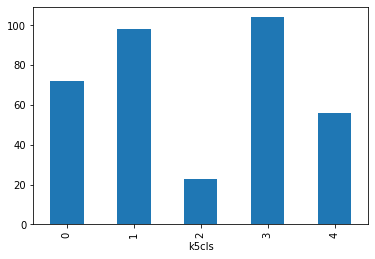

In [14]:
_ = k5sizes.plot.bar()

As we suspected from the map, groups varying sizes, with groups zero, three and four being over 75 observations each, and one and two being under twenty.

In order to describe the nature of each category, we can look at the values of each of the attributes we have used to create them in the first place. Remember we used the average ratings on many aspects (cleanliness, communication of the host, etc.) to create the classification, so we can begin by checking the average value of each. To do that in Python, we will rely on the `groupby` operator which we will combine it with the function `mean`:

In [15]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[ratings].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
review_scores_rating,92.134328,95.330624,88.322160,93.727497,90.725593
review_scores_accuracy,9.472732,9.717272,9.149055,9.605591,9.355684
review_scores_cleanliness,9.214409,9.478406,8.907681,9.328059,9.132700
review_scores_checkin,9.588242,9.785712,9.413322,9.679087,9.510472
review_scores_communication,9.627248,9.804255,9.444095,9.722030,9.543217
review_scores_location,9.546235,9.539375,9.454598,9.443591,9.448517
review_scores_value,9.220018,9.531206,8.901364,9.384535,9.090933


This concludes the section on geodemographics. As we have seen, the essence of this approach is to group areas based on a purely statistical basis: *where* each area is located is irrelevant for the label it receives from the clustering algorithm. In many contexts, this is not only permissible but even desirable, as the interest is to see if particular combinations of values are distributed over space in any discernible way. However, in other context, we may be interested in created groups of observations that follow certain spatial constraints. For that, we now turn into regionalization techniques.

## Regionalization algorithms

Regionalization is the subset of clustering techniques that impose a spatial constraint on the classification. In other words, the result of a regionalization algorithm contains areas that are spatially contiguous. Efectively, what this means is that these techniques aggregate areas into a smaller set of larger ones, called regions. In this context then, areas are *nested* within regions. Real world examples of this phenomenon includes counties within states or, in the UK, local super output areas (LSOAs) into middle super output areas (MSOAs). The difference between those examples and the output of a regionalization algorithm is that while the former are aggregated based on administrative principles, the latter follows a statistical technique that, very much the same as in the standard statistical clustering, groups together areas that are similar on the basis of a set of attributes. Only that now, such statistical clustering is spatially constrained.

As in the non-spatial case, there are many different algorithms to perform regionalization, and they all differ on details relating to the way they measure (dis)similarity, the process to regionalize, etc. However, same as above too, they all share a few common aspects. In particular, they all take a set of input attributes *and* a representation of space in the form of a binary spatial weights matrix. Depending on the algorithm, they also require the desired number of output regions into which the areas are aggregated.

To illustrate these concepts, we will run a regionalization algorithm on the AirBnb data we have been using. In this case, the goal will be to re-delineate the boundary lines of the Inner London boroughs following a rationale based on the different average ratings on AirBnb proeperties, instead of the administrative reasons behind the existing boundary lines. In this way, the resulting regions will represent a consistent set of areas that are similar with each other in terms of the ratings received.

### Defining space formally

Very much in the same way as with ESDA techniques, regionalization methods require a formal representation of space that is statistics-friendly. In practice, this means that we will need to create a spatial weights matrix for the areas to be aggregated. 

Technically speaking, this is the same process as we have seen before, thanks to `PySAL`. The difference in this case is that we did not begin with a shapefile, but with a GeoJSON. Fortunately, `PySAL` supports the construction of spatial weights matrices "on-the-fly", that is from a table. This is a one-liner:

In [16]:
w = weights.Queen.from_dataframe(abb)

### Creating regions from areas

At this point, we have all the pieces needed to run a regionalization algorithm. For this example, we will use a spatially-constrained version of the agglomerative algorithm. This is a similar approach to that used above (the inner-workings of the algorithm are different however) with the difference that, in this case, observations can only be labelled in the same group if they are spatial neighbors, as defined by our spatial weights matrix `w`. The way to interact with the algorithm is very similar to that above. We first set the parameters:

In [17]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<353x353 sparse matrix of type '<class 'numpy.float64'>'
	with 1978 stored elements in Compressed Sparse Row format>,
                        n_clusters=13)

And we can run the algorithm by calling `fit`:

In [18]:
# Run the clustering algorithm
sagg13cls = sagg13.fit(abb[ratings])

And then we append the labels to the table:

In [19]:
abb['sagg13cls'] = sagg13cls.labels_

### Mapping the resulting regions

At this point, the column `sagg13cls` is no different than `k5cls`: a categorical variable that can be mapped into a unique values choropleth. In fact the following code snippett is exactly the same as before, only replacing the name of the variable to be mapped and the title:

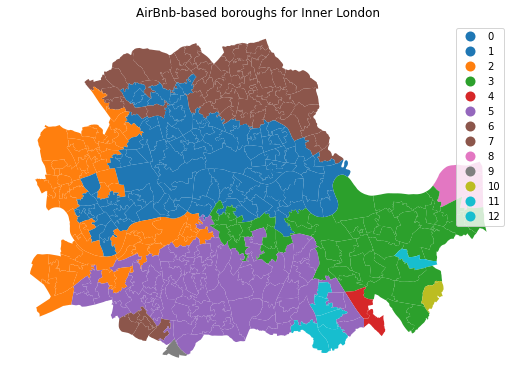

In [20]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London')
# Display the map
plt.show()

### Comparing organic and administrative delineations

The map above gives a very clear impression of the boundary delineation of the algorithm. However, it is still based on the small area polygons. To create the new boroughs "properly", we need to dissolve all the polygons in each category into a single one. This is a standard GIS operation that is supported by `geopandas` and that can be easily actioned with the same `groupby` operator we used before. The only additional complication is that we need to wrap it into a separate function to be able to pass it on to `groupby`. We first the define the function `dissolve`:

In [21]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

The boundaries for the AirBnb boroughs can then be obtained as follows:

In [22]:
# Dissolve the polygons based on `sagg13cls`
abb_boroughs = gpd.GeoSeries(abb.groupby(abb['sagg13cls'])\
                                .apply(dissolve),
                             crs=abb.crs
                            )

Which we can plot:

Text(0.5, 1.0, 'AirBnb-based boroughs for Inner London')

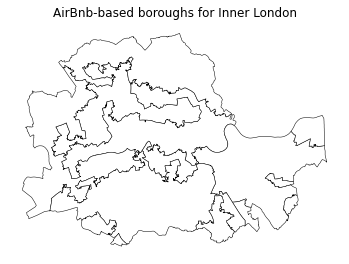

In [23]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
abb_boroughs.plot(ax=ax, 
                  linewidth=0.5,
                  facecolor='white', 
                  edgecolor='k'
                 )
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London')

The delineation above provides a view into the geography of AirBnb properties. Each region delineated contains houses that, according to our regionalisation algorithm, are more similar with each other than those in the neighboring areas. Now let's compare this geography that we have organically drawn from our data with that of the official set of administrative boundaries. For example, with the London boroughs.

Remember we read these at the beginning of the notebook:

In [24]:
boroughs.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Lambeth,E09000022,2724.940,43.927,T,None,None,"POLYGON ((-0.12846 51.48505, -0.12843 51.48506..."
1,Southwark,E09000028,2991.340,105.139,T,None,None,"POLYGON ((-0.10892 51.50844, -0.10889 51.50845..."
2,Lewisham,E09000023,3531.706,16.795,T,None,None,"POLYGON ((-0.03241 51.49306, -0.03240 51.49303..."
3,Greenwich,E09000011,5044.190,310.785,F,None,None,"MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51..."
4,Wandsworth,E09000032,3522.022,95.600,T,None,None,"POLYGON ((-0.22343 51.47152, -0.22327 51.47146..."


And displayed in a similar way as with the newly created ones:

Text(0.5, 1.0, 'Administrative boroughs for Inner London')

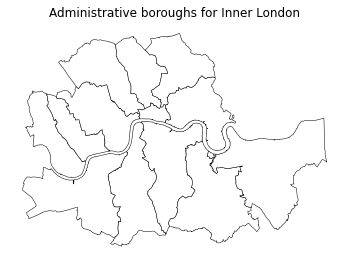

In [25]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
boroughs.plot(ax=ax, 
              linewidth=0.5,
              edgecolor='k', 
              facecolor='white'
             )
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Administrative boroughs for Inner London')

In order to more easily compare the administrative and the "regionalized" boundary lines, we can overlay them:

```{margin}
The code to create this figure is hidden to facilitate the flow of the narrative but you can toggle it open. It combines building blocks we have seen previously in this course
```

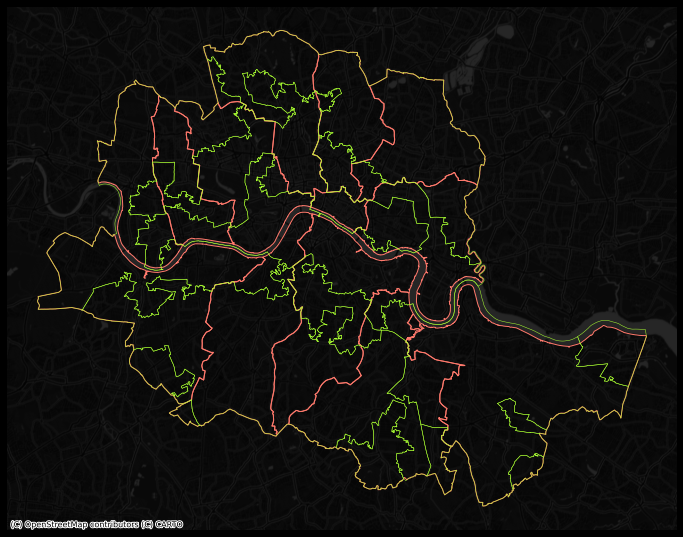

In [26]:
# Set up figure
f, ax = plt.subplots(1, figsize=(12, 12))
f.set_facecolor("k")

# Add boroughs
boroughs.to_crs(epsg=22770)\
        .plot(ax=ax,
              facecolor="none",
              edgecolor="xkcd:salmon",
              linewidth=1
             )

# Add regionalisation geography
abb_boroughs.to_crs(epsg=22770)\
            .plot(ax=ax,
                  facecolor="none",
                  edgecolor="xkcd:lime",
                  linewidth=0.5
                 )

# Add basemap
cx.add_basemap(ax,
               crs="EPSG:22770",
               source=cx.providers.CartoDB.DarkMatterNoLabels
              )

# Remove axis
ax.set_axis_off()
# Display clean
plt.show()

Looking at the figure, there are several differences between the two maps. The clearest one is that, while the administrative boundaries have a very balanced size (with the exception of the city of London), the regions created with the spatial agglomerative algorithm are very different in terms of size between each other. This is a consequence of both the nature of the underlying data and the algorithm itself. Substantively, this shows how, based on AirBnb, we can observe large areas that are similar and hence are grouped into the same region, while there also exist pockets with characteristics different enough to be assigned into a different region.